In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml Pillow opencv-python numpy matplotlib

In [ ]:
!cp /content/drive/MyDrive/YoloProj/dataset.py /content/
!cp -r /content/drive/MyDrive/YoloProj/transparent2/ /content/transparent/


!ls /content
!ls /content/transparent

cp: cannot stat '/content/drive/MyDrive/YoloProj/dataset.py': No such file or directory
drive  sample_data  transparent
coin.png     coral.png	  diamond.png  fossil.png  letter.png  treasure_box.png
compass.png  crystal.png  emerald.png  key.png	   shell.png


In [ ]:
from PIL import Image
import os
import random
import math
import shutil

#--- Configuration (CM values remain global) ---
# DPI is now set per image
# CM_TO_PX will be defined per image based on current DPI

#--- Overall Page Dimensions (CM) ---
PAGE_WIDTH_CM = 27.0
PAGE_HEIGHT_CM = 17.7

#--- Target Item Display Area Properties (CM) ---
PAGE_MARGIN_CM = 0.5 # Small margin from page edge for item placement
DISPLAY_AREA_X_FROM_PAGE_LEFT_CM = PAGE_MARGIN_CM
DISPLAY_AREA_Y_FROM_PAGE_TOP_CM = PAGE_MARGIN_CM
DISPLAY_AREA_WIDTH_CM = PAGE_WIDTH_CM - (2 * PAGE_MARGIN_CM)
DISPLAY_AREA_HEIGHT_CM = PAGE_HEIGHT_CM - (2 * PAGE_MARGIN_CM)

#--- Item properties (CM and global settings) ---
MIN_ITEM_SIZE_CM = 3.0
MAX_ITEM_SIZE_CM = 12.0
MAX_ITEMS_TO_DISPLAY = 5
MIN_ITEMS_TO_DISPLAY = 1 # Will be adjusted to min 2 for overlap scenarios
ITEM_PLACEMENT_ATTEMPTS = 100
FORCED_OVERLAP_PLACEMENT_ATTEMPTS = 150
ITEM_PADDING_CM = 0.1 # Padding for non-forced overlaps

#--- Rotation Configuration ---
MIN_ROTATION_ANGLE = -180
MAX_ROTATION_ANGLE = 180

# --- Paths and Dataset Config ---
ITEM_IMAGE_FOLDER = "/content/transparent/" # Adjust as needed
OUTPUT_FOLDER = "generated_yolo_dataset/" # Adjust as needed

NUMBER_OF_IMAGES_TO_GENERATE = 1200
VALIDATION_SPLIT_RATIO = 0.2

# --- Item Categories ---
TARGET_ITEM_BASENAMES = ["diamond", "emerald", "crystal"]
LOST_ITEM_BASENAMES = ["key", "coin", "treasure_box", "shell", "compass", "letter", "coral", "fossil"]

# --- DPI Configuration for generation ---
HIGH_DPI_CHANCE = 0.20 # 20%
HIGH_DPI_VALUE = 100
REGULAR_DPI_MIN = 10
REGULAR_DPI_MAX = 20


# --- Helper Functions ---
def resize_item(item_img, max_target_dim_px, min_target_dim_px): # Takes pixel dimensions
    original_width, original_height = item_img.size
    # Ensure min_target_dim_px is not greater than max_target_dim_px
    if min_target_dim_px > max_target_dim_px :
        min_target_dim_px = max_target_dim_px # cap it or swap, here capping
    if min_target_dim_px <= 0 : min_target_dim_px = 1 # ensure positive

    target_dim_px = random.randint(min_target_dim_px, max_target_dim_px)
    if original_width == 0 or original_height == 0:
        return item_img.resize((target_dim_px, target_dim_px), Image.Resampling.LANCZOS)
    current_max_orig_dim = max(original_width, original_height)
    if current_max_orig_dim == 0:
        return item_img.resize((target_dim_px, target_dim_px), Image.Resampling.LANCZOS)
    scale_factor = target_dim_px / current_max_orig_dim
    new_width = max(1, int(original_width * scale_factor))
    new_height = max(1, int(original_height * scale_factor))
    return item_img.resize((new_width, new_height), Image.Resampling.LANCZOS)

def check_overlap(box1, box2, padding_px=0): # (x1, y1, x2, y2)
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2
    return not (b1_x2 + padding_px < b2_x1 - padding_px or
                b1_x1 - padding_px > b2_x2 + padding_px or
                b1_y2 + padding_px < b2_y1 - padding_px or
                b1_y1 - padding_px > b2_y2 + padding_px)

def place_item_normally(item_img_rgba, display_x1_px, display_y1_px, display_x2_px, display_y2_px,
                        existing_bboxes, padding_px, placement_attempts):
    item_w, item_h = item_img_rgba.size
    if item_w == 0 or item_h == 0: return None, None
    if display_x2_px - display_x1_px < item_w or display_y2_px - display_y1_px < item_h:
        return None, None

    for _ in range(placement_attempts):
        # Ensure max is not less than min for randint.
        max_x_coord_rand = display_x2_px - item_w
        max_y_coord_rand = display_y2_px - item_h

        if max_x_coord_rand < display_x1_px or max_y_coord_rand < display_y1_px:
             # This can happen if item_w is very close to display_width
             # Adjust to ensure randint range is valid
             max_x_coord = max(display_x1_px, max_x_coord_rand)
             max_y_coord = max(display_y1_px, max_y_coord_rand)
             if max_x_coord < display_x1_px or max_y_coord < display_y1_px:
                 return None, None # Item simply too big or display area too small
             pos_x = random.randint(display_x1_px, max_x_coord)
             pos_y = random.randint(display_y1_px, max_y_coord)
        else:
            pos_x = random.randint(display_x1_px, max_x_coord_rand)
            pos_y = random.randint(display_y1_px, max_y_coord_rand)

        current_bbox_abs = (pos_x, pos_y, pos_x + item_w, pos_y + item_h)

        is_overlapping_existing = False
        for existing_bbox in existing_bboxes:
            if check_overlap(current_bbox_abs, existing_bbox, padding_px=padding_px):
                is_overlapping_existing = True
                break
        if not is_overlapping_existing:
            return (pos_x, pos_y), current_bbox_abs
    return None, None

def place_item_with_forced_overlap(item_img_rgba, ref_bbox,
                                   display_x1_px, display_y1_px, display_x2_px, display_y2_px,
                                   other_existing_bboxes, padding_for_others_px, placement_attempts):
    item_w, item_h = item_img_rgba.size
    if item_w == 0 or item_h == 0: return None, None
    ref_x1, ref_y1, ref_x2, ref_y2 = ref_bbox

    for _ in range(placement_attempts):
        range_x_min = ref_x1 - int(item_w * 0.75)
        range_x_max = ref_x2 - int(item_w * 0.25)
        range_y_min = ref_y1 - int(item_h * 0.75)
        range_y_max = ref_y2 - int(item_h * 0.25)

        if range_x_min >= range_x_max or range_y_min >= range_y_max:
            pos_x = ref_x1 + (ref_x2 - ref_x1) // 2 - item_w // 2 + random.randint(-item_w // 4, item_w // 4)
            pos_y = ref_y1 + (ref_y2 - ref_y1) // 2 - item_h // 2 + random.randint(-item_h // 4, item_h // 4)
        else:
            pos_x = random.randint(range_x_min, range_x_max)
            pos_y = random.randint(range_y_min, range_y_max)

        pos_x = max(display_x1_px, min(pos_x, display_x2_px - item_w))
        pos_y = max(display_y1_px, min(pos_y, display_y2_px - item_h))

        if pos_x + item_w <= display_x1_px or pos_x >= display_x2_px or \
           pos_y + item_h <= display_y1_px or pos_y >= display_y2_px or \
           display_x2_px - item_w < display_x1_px or display_y2_px - item_h < display_y1_px:
            continue

        current_bbox_abs = (pos_x, pos_y, pos_x + item_w, pos_y + item_h)
        if not check_overlap(current_bbox_abs, ref_bbox, padding_px=0):
            continue

        overlaps_others = False
        for other_bbox in other_existing_bboxes:
            if check_overlap(current_bbox_abs, other_bbox, padding_px=padding_for_others_px):
                overlaps_others = True
                break
        if not overlaps_others:
            return (pos_x, pos_y), current_bbox_abs
    return None, None

# MODIFIED: Takes current pixel dimensions for resizing
def process_item_file(filename, class_to_id_map, class_names_list,
                      current_max_item_dim_px, current_min_item_dim_px):
    item_path = os.path.join(ITEM_IMAGE_FOLDER, filename)
    item_base_name = os.path.splitext(filename)[0]
    canonical_name = item_base_name
    for target_bn in TARGET_ITEM_BASENAMES:
        if item_base_name.startswith(target_bn):
            canonical_name = target_bn
            break
    if canonical_name == item_base_name:
        for lost_bn in LOST_ITEM_BASENAMES:
            if item_base_name.startswith(lost_bn):
                canonical_name = lost_bn
                break

    if canonical_name not in class_to_id_map:
        new_id = len(class_names_list)
        class_to_id_map[canonical_name] = new_id
        class_names_list.append(canonical_name)
    current_class_id = class_to_id_map[canonical_name]

    try:
        item_obj_original_rgba = Image.open(item_path).convert("RGBA")
    except FileNotFoundError:
        print(f"Warning: Item image not found {item_path}")
        return None

    # Use passed-in pixel dimensions for resizing
    item_obj_resized_rgba = resize_item(item_obj_original_rgba, current_max_item_dim_px, current_min_item_dim_px)
    rotation_angle = random.uniform(MIN_ROTATION_ANGLE, MAX_ROTATION_ANGLE)
    item_obj_processed_rgba = item_obj_resized_rgba.rotate(rotation_angle, resample=Image.BICUBIC, expand=True)
    if item_obj_processed_rgba.width == 0 or item_obj_processed_rgba.height == 0:
        return None
    return {'img': item_obj_processed_rgba, 'class_id': current_class_id, 'name': canonical_name, 'filename': filename}

# --- Main Generation ---
if __name__ == "__main__":
    print(f"Using ITEM_IMAGE_FOLDER: {ITEM_IMAGE_FOLDER}")
    print(f"Using OUTPUT_FOLDER: {OUTPUT_FOLDER}")

    if not os.path.exists(ITEM_IMAGE_FOLDER):
        print(f"Error: Item image folder '{ITEM_IMAGE_FOLDER}' does not exist.")
        exit()

    if os.path.exists(OUTPUT_FOLDER):
        print(f"Output folder '{OUTPUT_FOLDER}' already exists. Removing it.")
        shutil.rmtree(OUTPUT_FOLDER)
    paths_to_create = [
        os.path.join(OUTPUT_FOLDER, "images", "train"), os.path.join(OUTPUT_FOLDER, "images", "val"),
        os.path.join(OUTPUT_FOLDER, "labels", "train"), os.path.join(OUTPUT_FOLDER, "labels", "val"),
    ]
    for p in paths_to_create: os.makedirs(p, exist_ok=True)

    all_item_files = [f for f in os.listdir(ITEM_IMAGE_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_item_files:
        print(f"Error: No suitable item images found in {ITEM_IMAGE_FOLDER}.")
        exit()

    available_target_item_files = []
    for f in all_item_files:
        base = os.path.splitext(f)[0]
        if any(base.startswith(target_bn) for target_bn in TARGET_ITEM_BASENAMES):
            available_target_item_files.append(f)

    available_lost_item_files = []
    for f in all_item_files:
        base = os.path.splitext(f)[0]
        if any(base.startswith(lost_bn) for lost_bn in LOST_ITEM_BASENAMES):
            available_lost_item_files.append(f)

    if not available_target_item_files: print("Warning: No target item images found. Target-lost overlap scenario might be affected.")
    if not available_lost_item_files: print("Warning: No lost item types/files found. Lost-lost and Target-lost overlap scenarios might be affected.")

    print(f"--- Layout Calculations (DPI will vary: {HIGH_DPI_CHANCE*100:.0f}% @ {HIGH_DPI_VALUE} DPI, {(1-HIGH_DPI_CHANCE)*100:.0f}% @ {REGULAR_DPI_MIN}-{REGULAR_DPI_MAX} DPI) ---")
    print(f"Item Rotation Range: {MIN_ROTATION_ANGLE} to {MAX_ROTATION_ANGLE} degrees")

    num_total_images = NUMBER_OF_IMAGES_TO_GENERATE
    TARGET_LOST_OVERLAP_PERCENTAGE = 0.15
    LOST_LOST_OVERLAP_PERCENTAGE = 0.15
    num_target_lost_overlap_required = math.ceil(num_total_images * TARGET_LOST_OVERLAP_PERCENTAGE)
    num_lost_overlap_required = math.ceil(num_total_images * LOST_LOST_OVERLAP_PERCENTAGE)
    image_generation_plan = []
    for _ in range(num_lost_overlap_required): image_generation_plan.append("lost_lost_overlap")
    for _ in range(num_target_lost_overlap_required): image_generation_plan.append("target_lost_overlap")
    num_normal_images_to_add = num_total_images - len(image_generation_plan)
    if num_normal_images_to_add < 0: num_normal_images_to_add = 0
    for _ in range(num_normal_images_to_add): image_generation_plan.append("normal")
    while len(image_generation_plan) < num_total_images: image_generation_plan.append("normal")
    random.shuffle(image_generation_plan)
    image_generation_plan = image_generation_plan[:num_total_images]
    plan_counts = {t: image_generation_plan.count(t) for t in set(image_generation_plan)}
    print(f"Image generation plan ({num_total_images} total):")
    for type_name, count in plan_counts.items():
        percentage = count / num_total_images * 100 if num_total_images > 0 else 0
        print(f"  - {type_name}: {count} images ({percentage:.1f}%)")

    all_generated_data = []
    class_to_id = {}
    class_names = []

    for i in range(num_total_images):
        # --- Determine DPI for the current image ---
        if random.random() < HIGH_DPI_CHANCE:
            current_dpi = HIGH_DPI_VALUE
        else:
            current_dpi = random.randint(REGULAR_DPI_MIN, REGULAR_DPI_MAX)

        # --- Define CM_TO_PX converter for the current DPI ---
        CM_TO_PX_current = lambda cm: int(cm / 2.54 * current_dpi)

        # --- Recalculate dimensions based on current_dpi ---
        current_canvas_width_px = CM_TO_PX_current(PAGE_WIDTH_CM)
        current_canvas_height_px = CM_TO_PX_current(PAGE_HEIGHT_CM)

        current_display_area_x1_px = CM_TO_PX_current(DISPLAY_AREA_X_FROM_PAGE_LEFT_CM)
        current_display_area_y1_px = CM_TO_PX_current(DISPLAY_AREA_Y_FROM_PAGE_TOP_CM)
        current_display_area_width_px = CM_TO_PX_current(DISPLAY_AREA_WIDTH_CM)
        current_display_area_height_px = CM_TO_PX_current(DISPLAY_AREA_HEIGHT_CM)
        current_display_area_x2_px = current_display_area_x1_px + current_display_area_width_px
        current_display_area_y2_px = current_display_area_y1_px + current_display_area_height_px

        current_min_item_dim_px = CM_TO_PX_current(MIN_ITEM_SIZE_CM)
        current_max_item_dim_px = CM_TO_PX_current(MAX_ITEM_SIZE_CM)
        current_item_padding_px = CM_TO_PX_current(ITEM_PADDING_CM)
        # --- End of DPI-based recalculations ---

        generation_type = image_generation_plan[i]
        canvas = Image.new("RGB", (current_canvas_width_px, current_canvas_height_px), "white")

        current_image_yolo_annotations = []
        placed_item_bboxes_abs = []

        min_items_for_current_image = MIN_ITEMS_TO_DISPLAY
        max_items_for_current_image = MAX_ITEMS_TO_DISPLAY
        if generation_type != "normal":
            if MAX_ITEMS_TO_DISPLAY < 2: generation_type = "normal"
            else: min_items_for_current_image = max(MIN_ITEMS_TO_DISPLAY, 2)
        if min_items_for_current_image > max_items_for_current_image: min_items_for_current_image = max_items_for_current_image
        num_items_to_place_total = random.randint(min_items_for_current_image, max_items_for_current_image)
        if num_items_to_place_total == 0 and generation_type != "normal":
             if MAX_ITEMS_TO_DISPLAY >=2: num_items_to_place_total = 2
             else:
                  num_items_to_place_total = MAX_ITEMS_TO_DISPLAY
                  generation_type = "normal"

        overlap_pair_data = []
        other_items_data = []
        processed_filenames_for_this_image = set()

        if generation_type == "lost_lost_overlap":
            if available_lost_item_files and len(available_lost_item_files) >= 1 and num_items_to_place_total >= 2:
                chosen_lost_item_file = random.choice(available_lost_item_files)
                item_data1 = process_item_file(chosen_lost_item_file, class_to_id, class_names, current_max_item_dim_px, current_min_item_dim_px)
                item_data2 = process_item_file(chosen_lost_item_file, class_to_id, class_names, current_max_item_dim_px, current_min_item_dim_px)
                if item_data1 and item_data2:
                    overlap_pair_data.append(item_data1)
                    overlap_pair_data.append(item_data2)
                    processed_filenames_for_this_image.add(chosen_lost_item_file)
                else: generation_type = "normal"
            else: generation_type = "normal"
        elif generation_type == "target_lost_overlap":
            if available_target_item_files and available_lost_item_files and num_items_to_place_total >= 2:
                target_file = random.choice(available_target_item_files)
                lost_file = random.choice(available_lost_item_files)
                item_data_target = process_item_file(target_file, class_to_id, class_names, current_max_item_dim_px, current_min_item_dim_px)
                item_data_lost = process_item_file(lost_file, class_to_id, class_names, current_max_item_dim_px, current_min_item_dim_px)
                if item_data_target and item_data_lost:
                    overlap_pair_data.append(item_data_target)
                    overlap_pair_data.append(item_data_lost)
                    processed_filenames_for_this_image.add(target_file)
                    processed_filenames_for_this_image.add(lost_file)
                else: generation_type = "normal"
            else: generation_type = "normal"

        num_remaining_to_select = num_items_to_place_total - len(overlap_pair_data)
        if num_remaining_to_select > 0:
            selectable_pool = [f for f in all_item_files if f not in processed_filenames_for_this_image]
            if selectable_pool:
                num_to_sample = min(num_remaining_to_select, len(selectable_pool))
                if num_to_sample > 0:
                    additional_files = random.sample(selectable_pool, num_to_sample)
                    for f_name in additional_files:
                        item_data = process_item_file(f_name, class_to_id, class_names, current_max_item_dim_px, current_min_item_dim_px)
                        if item_data: other_items_data.append(item_data)

        item1_bbox_from_pair = None
        if overlap_pair_data:
            item1_data = overlap_pair_data[0]
            pos1, bbox1 = place_item_normally(item1_data['img'], current_display_area_x1_px, current_display_area_y1_px, current_display_area_x2_px, current_display_area_y2_px,
                                              placed_item_bboxes_abs, current_item_padding_px, ITEM_PLACEMENT_ATTEMPTS)
            if pos1:
                canvas.paste(item1_data['img'], pos1, item1_data['img'])
                placed_item_bboxes_abs.append(bbox1)
                item1_bbox_from_pair = bbox1
                xc = (pos1[0] + item1_data['img'].width / 2) / current_canvas_width_px
                yc = (pos1[1] + item1_data['img'].height / 2) / current_canvas_height_px
                w = item1_data['img'].width / current_canvas_width_px
                h = item1_data['img'].height / current_canvas_height_px
                current_image_yolo_annotations.append(f"{item1_data['class_id']} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
            else:
                other_items_data.extend(overlap_pair_data)
                overlap_pair_data.clear()

        if overlap_pair_data and len(overlap_pair_data) > 1 and item1_bbox_from_pair:
            item2_data = overlap_pair_data[1]
            bboxes_to_avoid_for_item2 = [b for b in placed_item_bboxes_abs if b != item1_bbox_from_pair]
            pos2, bbox2 = place_item_with_forced_overlap(item2_data['img'], item1_bbox_from_pair,
                                                         current_display_area_x1_px, current_display_area_y1_px, current_display_area_x2_px, current_display_area_y2_px,
                                                         bboxes_to_avoid_for_item2, current_item_padding_px, FORCED_OVERLAP_PLACEMENT_ATTEMPTS)
            if pos2:
                canvas.paste(item2_data['img'], pos2, item2_data['img'])
                placed_item_bboxes_abs.append(bbox2)
                xc = (pos2[0] + item2_data['img'].width / 2) / current_canvas_width_px
                yc = (pos2[1] + item2_data['img'].height / 2) / current_canvas_height_px
                w = item2_data['img'].width / current_canvas_width_px
                h = item2_data['img'].height / current_canvas_height_px
                current_image_yolo_annotations.append(f"{item2_data['class_id']} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
            else:
                other_items_data.append(item2_data)

        random.shuffle(other_items_data)
        for item_data in other_items_data:
            pos, bbox = place_item_normally(item_data['img'], current_display_area_x1_px, current_display_area_y1_px, current_display_area_x2_px, current_display_area_y2_px,
                                            placed_item_bboxes_abs, current_item_padding_px, ITEM_PLACEMENT_ATTEMPTS)
            if pos:
                canvas.paste(item_data['img'], pos, item_data['img'])
                placed_item_bboxes_abs.append(bbox)
                xc = (pos[0] + item_data['img'].width / 2) / current_canvas_width_px
                yc = (pos[1] + item_data['img'].height / 2) / current_canvas_height_px
                w = item_data['img'].width / current_canvas_width_px
                h = item_data['img'].height / current_canvas_height_px
                current_image_yolo_annotations.append(f"{item_data['class_id']} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

        all_generated_data.append((canvas.copy(), current_image_yolo_annotations))
        if (i + 1) % max(1, (num_total_images // 10)) == 0 or i == 0 or (i + 1) == num_total_images:
            items_placed_count = len(current_image_yolo_annotations)
            actual_gen_type = generation_type
            if generation_type != "normal":
                if items_placed_count < 2 : actual_gen_type = f"{generation_type} (fallback: <2 items)"
            elif generation_type == "normal" and items_placed_count == 0: actual_gen_type = f"normal (0 items placed)"
            print(f"Generated data for image {i+1}/{num_total_images} (DPI: {current_dpi}, Type: {actual_gen_type}, Items: {items_placed_count})...")

    random.shuffle(all_generated_data)
    num_val_images = int(num_total_images * VALIDATION_SPLIT_RATIO)
    num_train_images = num_total_images - num_val_images
    train_data = all_generated_data[:num_train_images]
    val_data = all_generated_data[num_train_images:]
    print(f"\nSplitting dataset: {num_train_images} training, {num_val_images} validation images.")

    def save_data_split(dataset_split, split_name_str):
        img_output_dir = os.path.join(OUTPUT_FOLDER, "images", split_name_str)
        lbl_output_dir = os.path.join(OUTPUT_FOLDER, "labels", split_name_str)
        for idx, (img_pil, yolo_ann_lines) in enumerate(dataset_split):
            image_filename_base = f"img_{split_name_str}_{idx+1:05d}"
            img_pil.save(os.path.join(img_output_dir, f"{image_filename_base}.png"))
            with open(os.path.join(lbl_output_dir, f"{image_filename_base}.txt"), "w") as f_ann:
                for line in yolo_ann_lines: f_ann.write(line + "\n")
        print(f"Saved {len(dataset_split)} images and labels to '{split_name_str}' set.")

    save_data_split(train_data, "train")
    save_data_split(val_data, "val")

    yaml_path = os.path.join(OUTPUT_FOLDER, "dataset.yaml")
    with open(yaml_path, "w") as f_yaml:
        f_yaml.write(f"path: {os.path.abspath(OUTPUT_FOLDER)} \n")
        f_yaml.write(f"train: images/train \n")
        f_yaml.write(f"val: images/val \n")
        f_yaml.write(f"test: \n\n")
        f_yaml.write(f"nc: {len(class_names)}\n")
        f_yaml.write(f"names: {class_names}\n")

    print(f"\nDataset generation complete. YOLO dataset created in '{os.path.abspath(OUTPUT_FOLDER)}'.")
    print(f"YAML configuration file: '{os.path.abspath(yaml_path)}'")
    print(f"Found {len(class_names)} classes: {class_names}")

Using ITEM_IMAGE_FOLDER: /content/transparent/
Using OUTPUT_FOLDER: generated_yolo_dataset/
Output folder 'generated_yolo_dataset/' already exists. Removing it.
--- Layout Calculations (DPI will vary: 20% @ 100 DPI, 80% @ 10-20 DPI) ---
Item Rotation Range: -180 to 180 degrees
Image generation plan (1200 total):
  - lost_lost_overlap: 180 images (15.0%)
  - normal: 840 images (70.0%)
  - target_lost_overlap: 180 images (15.0%)
Generated data for image 1/1200 (DPI: 100, Type: target_lost_overlap, Items: 2)...
Generated data for image 120/1200 (DPI: 10, Type: normal, Items: 3)...
Generated data for image 240/1200 (DPI: 19, Type: normal, Items: 2)...
Generated data for image 360/1200 (DPI: 13, Type: normal, Items: 2)...
Generated data for image 480/1200 (DPI: 17, Type: normal, Items: 3)...
Generated data for image 600/1200 (DPI: 19, Type: normal, Items: 3)...
Generated data for image 720/1200 (DPI: 17, Type: target_lost_overlap, Items: 4)...
Generated data for image 840/1200 (DPI: 100, Ty

In [ ]:
#---------------------------------------------------------------------------------
# Cell 5: Clone YOLOv5 Repository and Install Requirements
#---------------------------------------------------------------------------------
import os

# Clone YOLOv5 repository
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git
else:
    print("yolov5 directory already exists.")

%cd yolov5
!pip install -qr requirements.txt  # install dependencies (quietly)

import torch
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
clear_output() # Clear output of this cell after execution

In [ ]:
#---------------------------------------------------------------------------------
# Cell 6: Train YOLOv5 Nano
#---------------------------------------------------------------------------------
# Define training parameters
# IMPORTANT: Adjust these as needed!
IMAGE_SIZE = 640
BATCH_SIZE = 32 # Adjust based on Colab GPU (P100/T4 can usually handle 16-32 for yolov5n)
EPOCHS = 100    # Start with 50-100, increase if mAP is still improving
DATA_YAML_PATH = '/content/generated_yolo_dataset/dataset.yaml' # Path to your generated dataset.yaml
WEIGHTS = 'yolov5n.pt' # Pre-trained YOLOv5 Nano weights
PROJECT_NAME = 'DETECTION' # Folder where runs will be saved inside yolov5/runs/train/
EXPERIMENT_NAME = 'expOverlapp2' # Specific name for this training run

# Construct the training command
# Note: %cd yolov5 should have been run in the previous cell, so we are in the yolov5 directory
!python train.py \
    --img {IMAGE_SIZE} \
    --batch {BATCH_SIZE} \
    --epochs {EPOCHS} \
    --data {DATA_YAML_PATH} \
    --weights {WEIGHTS} \
    --cfg models/yolov5n.yaml \
    --project {PROJECT_NAME} \
    --name {EXPERIMENT_NAME} \

# --exist-ok is useful for iterative development in Colab
# Remove it if you want each run to create a new exp, exp2, etc.

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      23/99      4.13G    0.03364    0.02221    0.02257        145        640:  43% 13/30 [00:07<00:15,  1.09it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      23/99      4.13G    0.03357    0.02212    0.02246        150        640:  47% 14/30 [00:08<00:12,  1.33it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      23/99      4.13G    0.03355    0.02223    0.02256        172        640:  50% 15/30 [00:09<00:14,  1.04it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):


Training Progress (results.png):


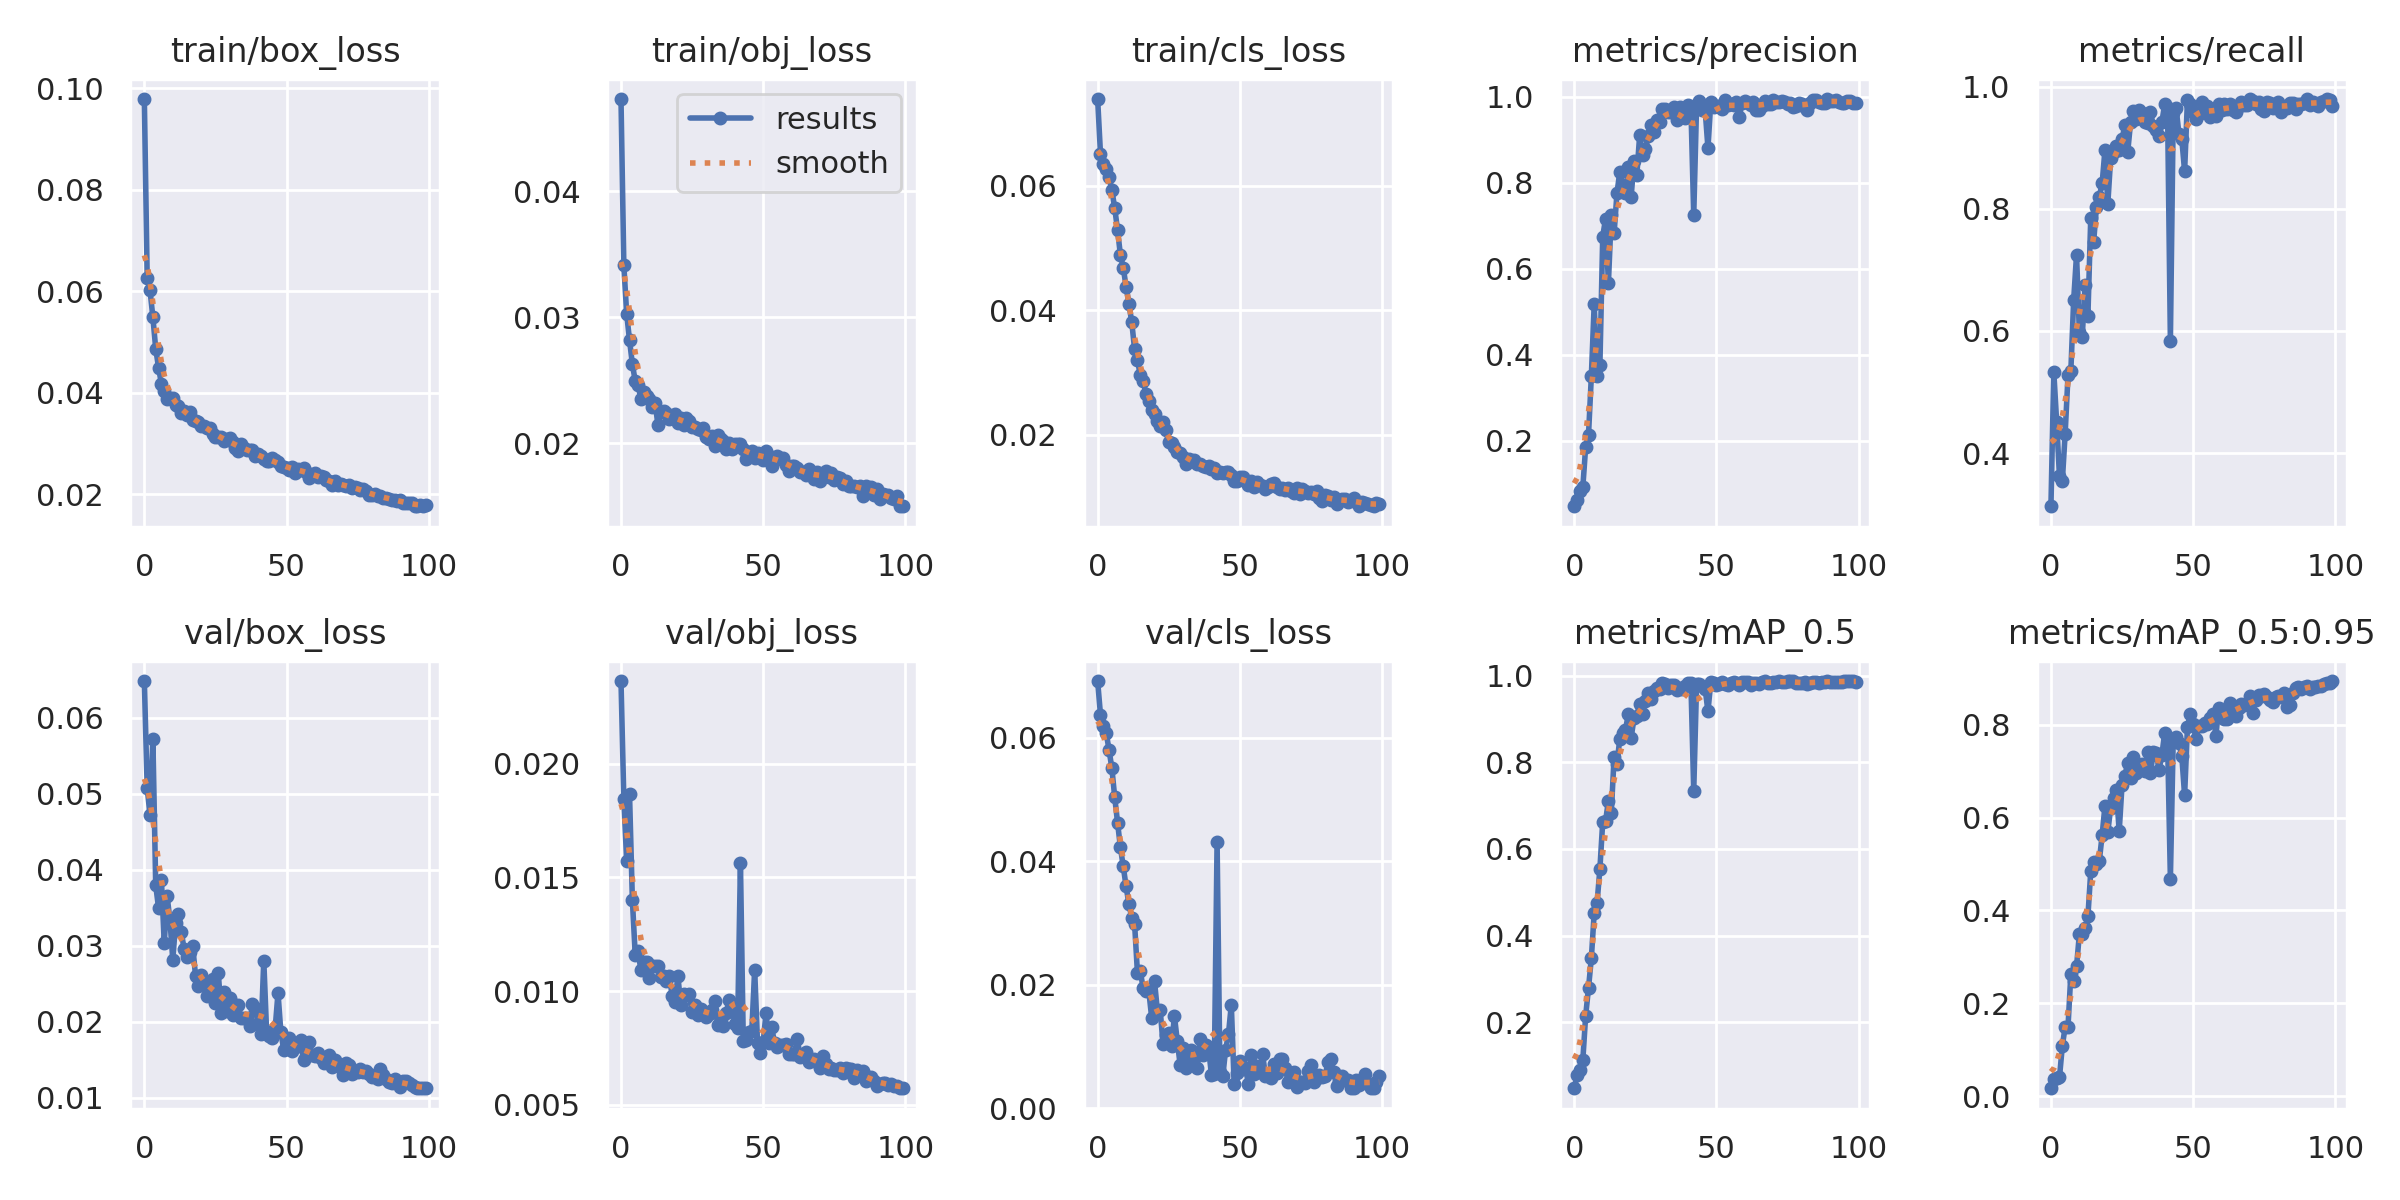


Confusion Matrix (confusion_matrix.png):


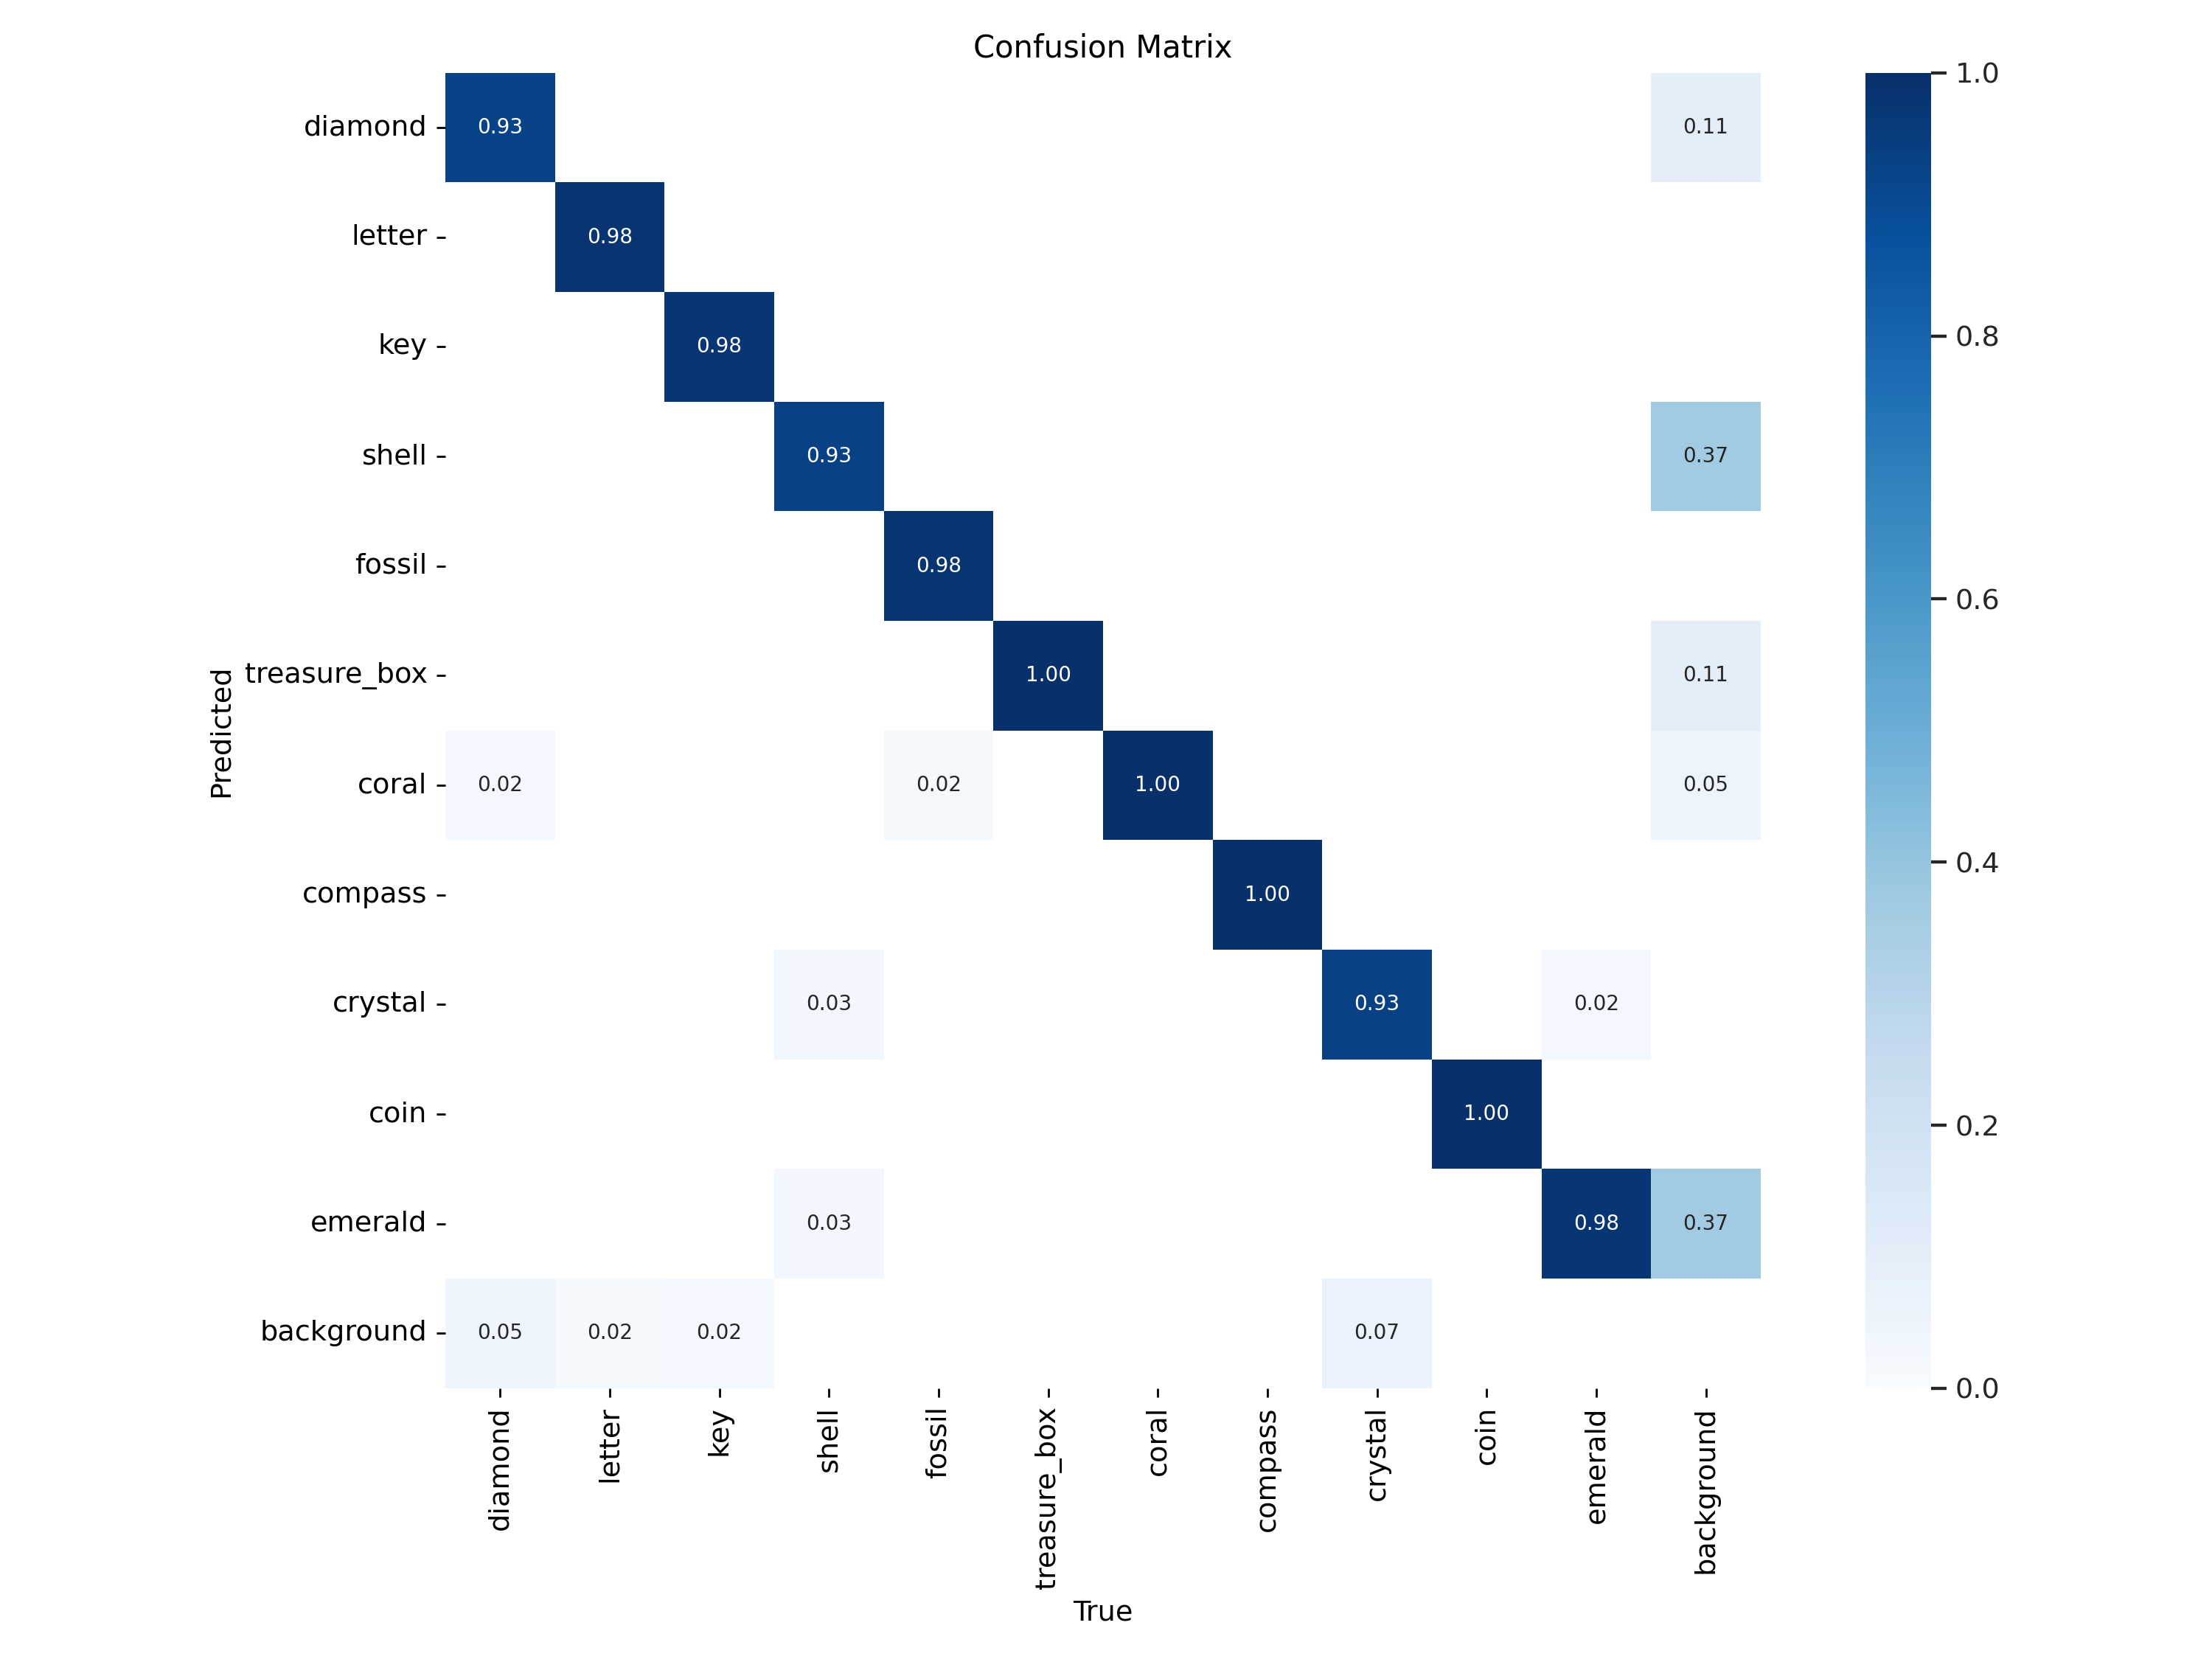


Validation Batch 0 - Labels:


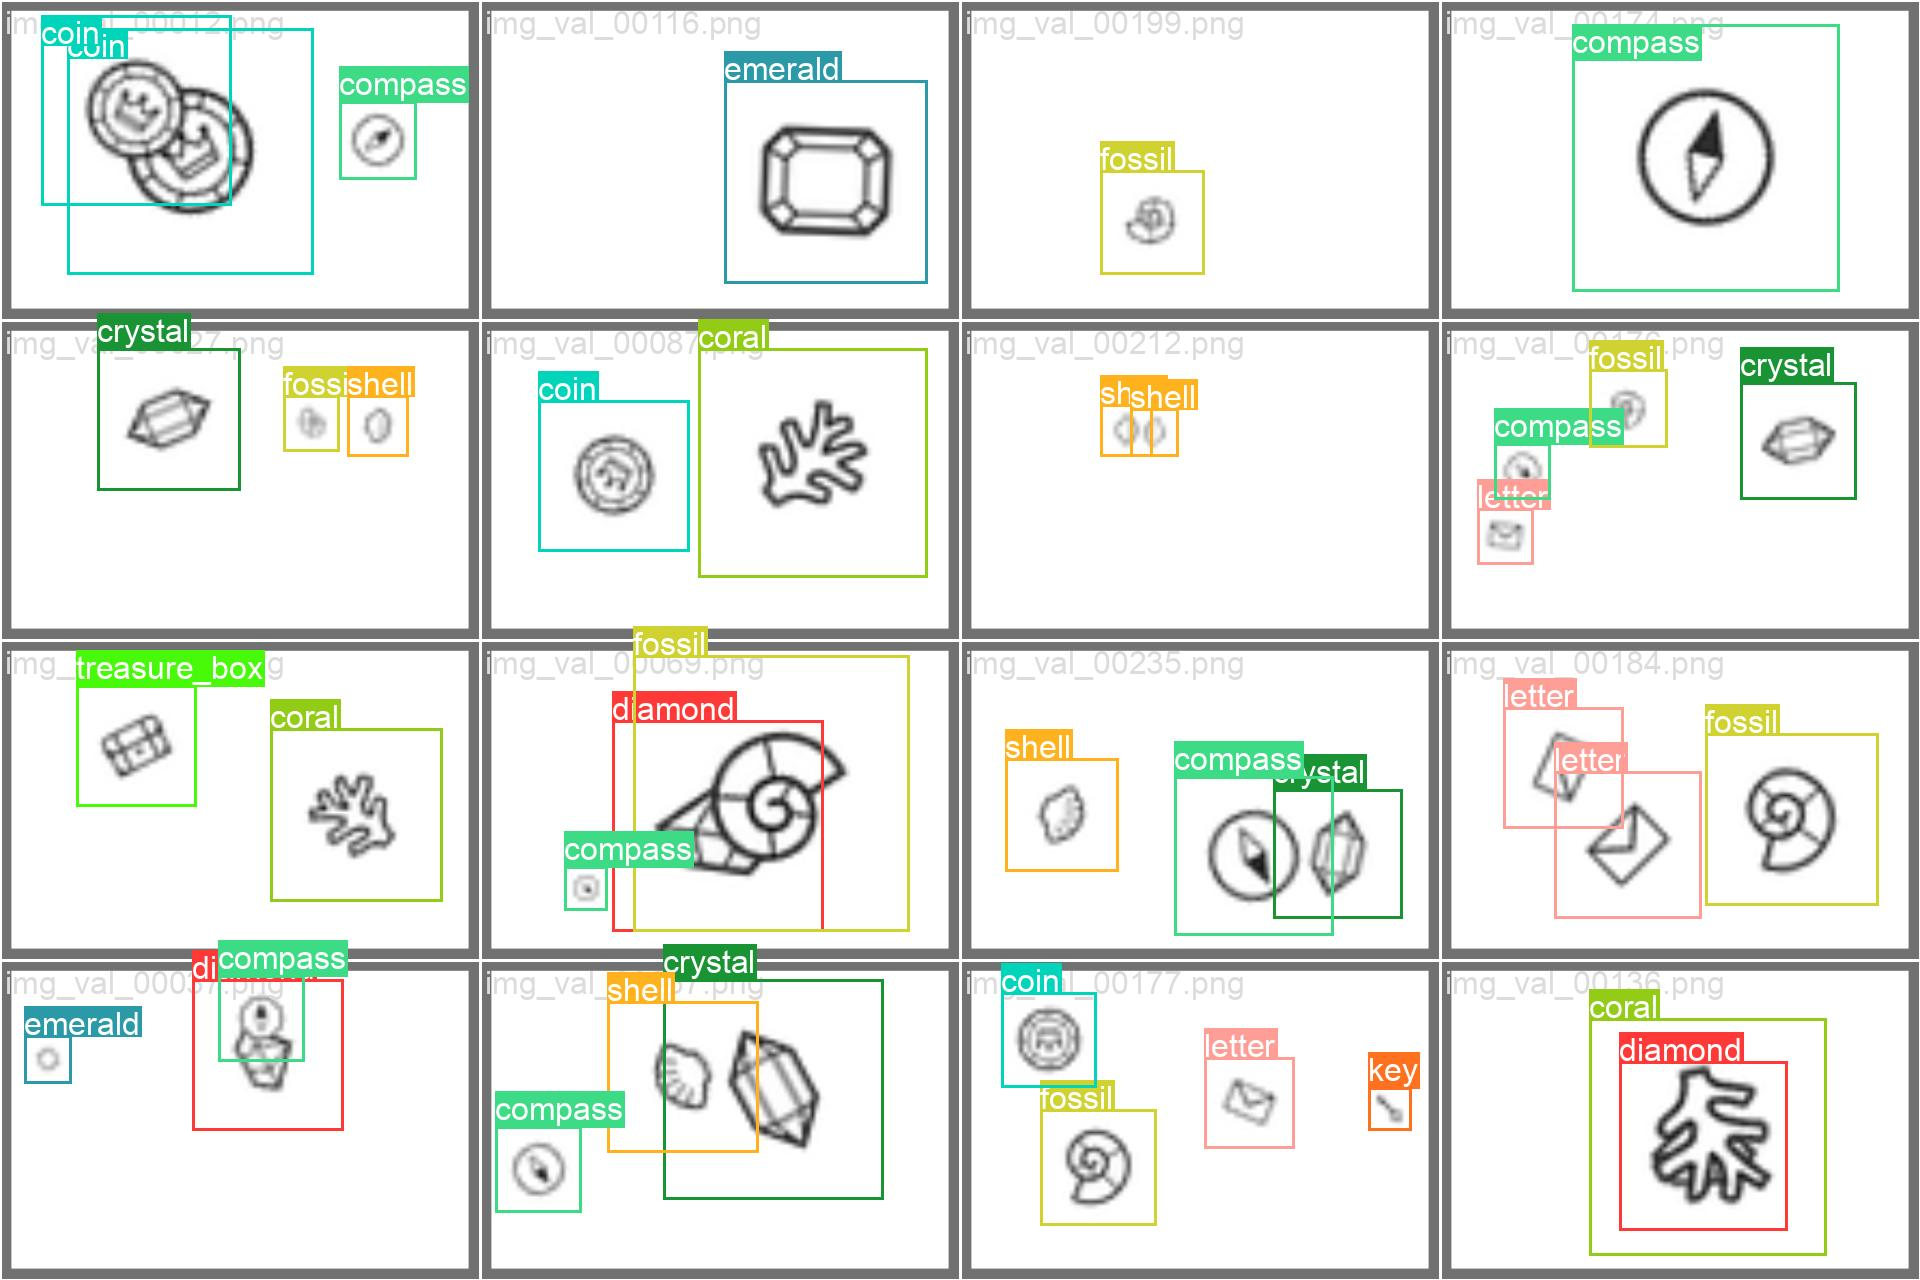


Validation Batch 0 - Predictions:


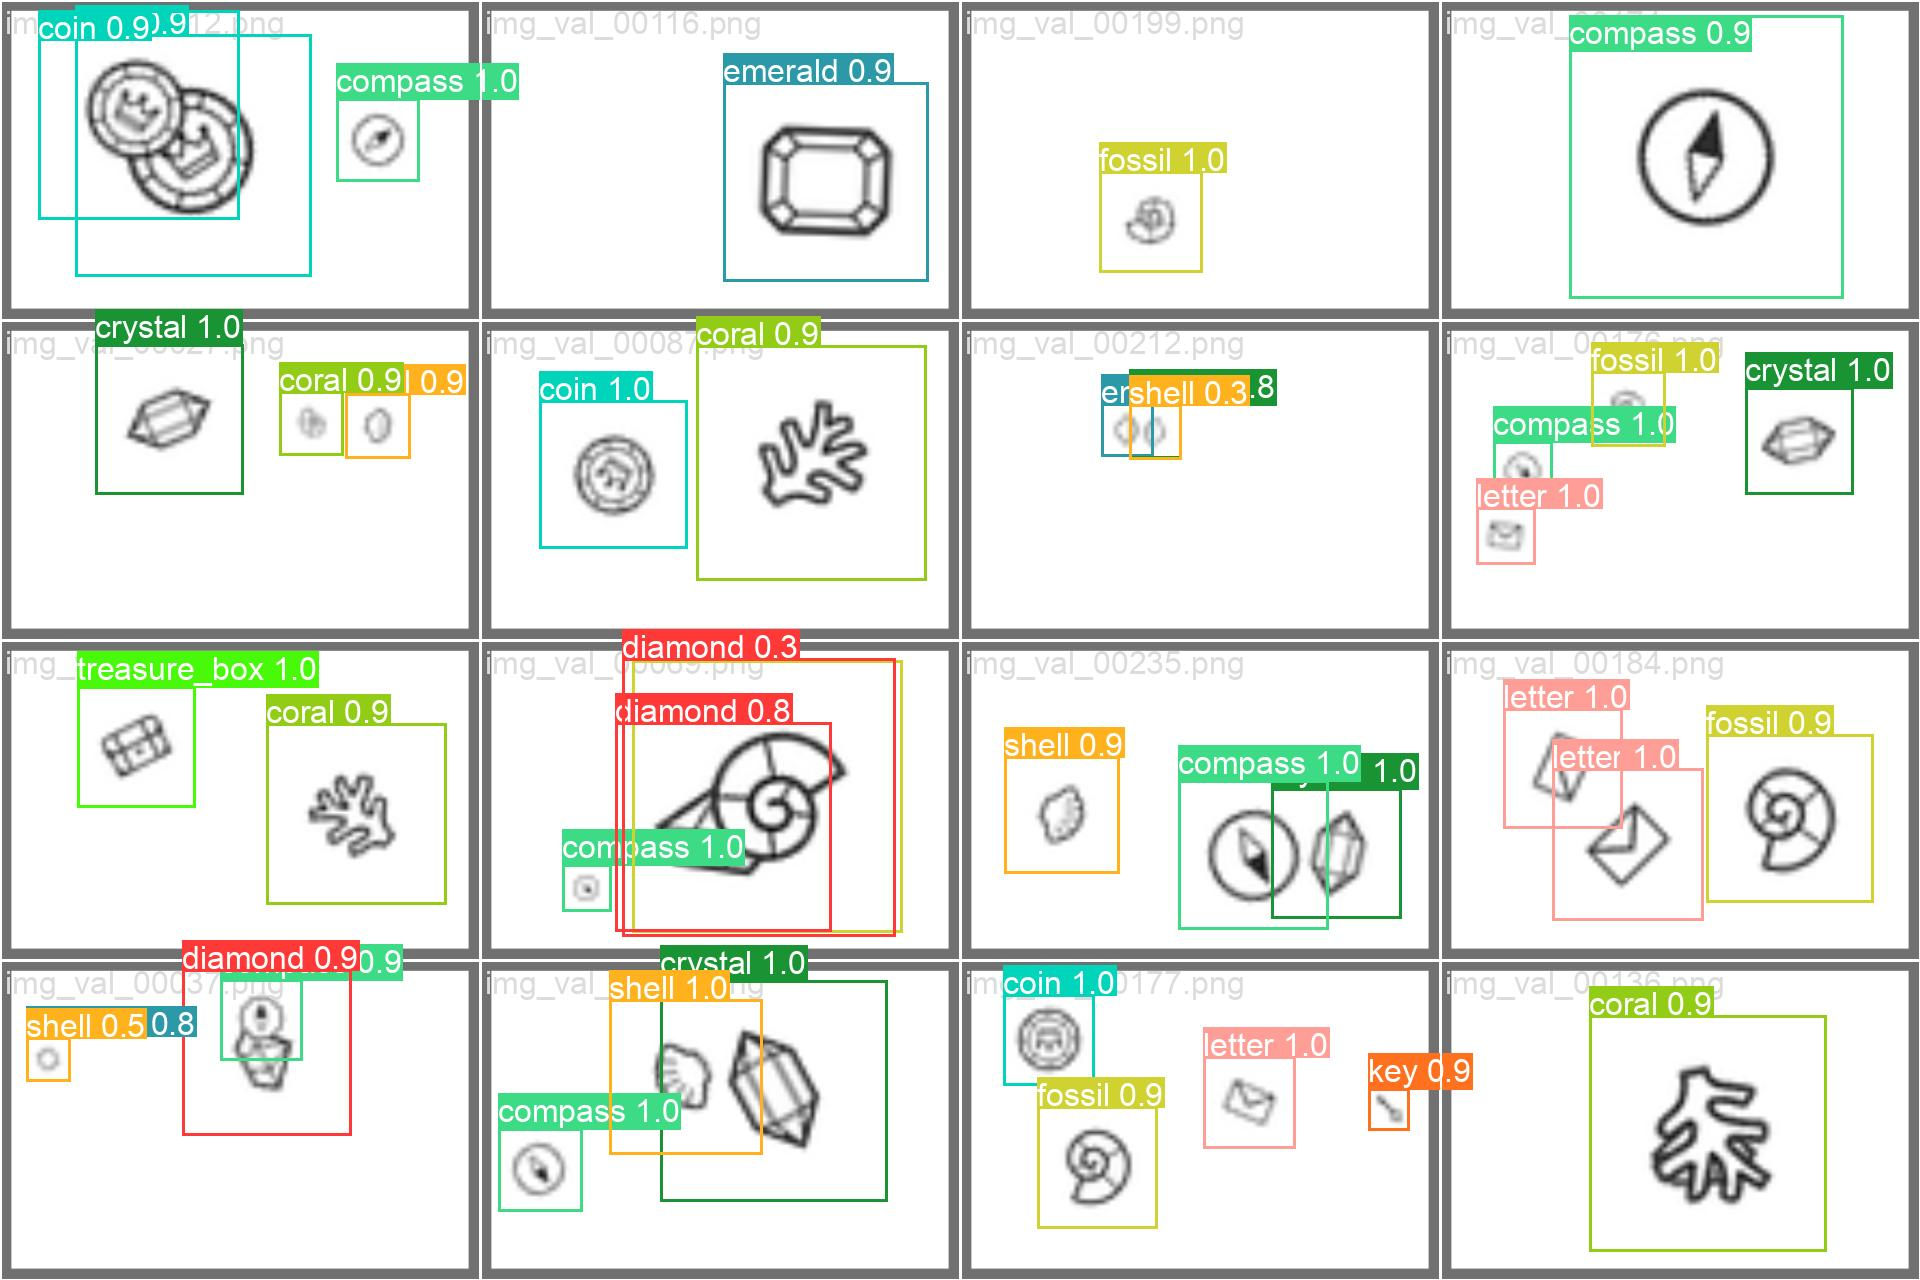

In [ ]:
#---------------------------------------------------------------------------------
# Cell 7: Display Training Results (Optional)
#---------------------------------------------------------------------------------
# The training script saves results including plots like results.png and confusion_matrix.png
# This cell shows how to display them.

# Replace EXPERIMENT_NAME if you changed it or if it incremented (e.g., my_custom_items_exp2)
results_path = f"{PROJECT_NAME}/{EXPERIMENT_NAME}/results.png"
confusion_matrix_path = f"{PROJECT_NAME}/{EXPERIMENT_NAME}/confusion_matrix.png"

if os.path.exists(results_path):
    print("Training Progress (results.png):")
    display(Image(filename=results_path))
else:
    print(f"results.png not found at {results_path}")

if os.path.exists(confusion_matrix_path):
    print("\nConfusion Matrix (confusion_matrix.png):")
    display(Image(filename=confusion_matrix_path))
else:
    print(f"confusion_matrix.png not found at {confusion_matrix_path}")

# You can also display example validation batch predictions
val_batch0_labels = f"{PROJECT_NAME}/{EXPERIMENT_NAME}/val_batch0_labels.jpg"
val_batch0_pred = f"{PROJECT_NAME}/{EXPERIMENT_NAME}/val_batch0_pred.jpg"

if os.path.exists(val_batch0_labels):
    print("\nValidation Batch 0 - Labels:")
    display(Image(filename=val_batch0_labels))
if os.path.exists(val_batch0_pred):
    print("\nValidation Batch 0 - Predictions:")
    display(Image(filename=val_batch0_pred))

In [ ]:
#---------------------------------------------------------------------------------
# Cell 8: Save Best Model to Google Drive (if mounted)
#---------------------------------------------------------------------------------
import shutil
import os

# === ENSURE THESE VARIABLES ARE THE SAME AS USED IN YOUR TRAINING CELL (Cell 6) ===
# These should match the --project and --name arguments from train.py
PROJECT_NAME_FROM_TRAINING = 'DETECTION'
EXPERIMENT_NAME_FROM_TRAINING = 'expOverlapp2' # <--- MAKE SURE THIS IS THE ACTUAL FOLDER (e.g., exp42)
# =================================================================================

# Current working directory should be /content/yolov5/ if you ran %cd /content/yolov5
# The training output "Results saved to DETECTION/exp42" implies this structure.
# Path to the best.pt file, relative to the current working directory (/content/yolov5/)
source_best_model_path_relative = os.path.join(PROJECT_NAME_FROM_TRAINING, EXPERIMENT_NAME_FROM_TRAINING, "weights", "best.pt")
# For clarity and absolute checking, let's form the absolute path as well
source_best_model_path_absolute = "DETECTION/expOverlapp2/weights/best.pt"


destination_drive_path = f"/content/drive/MyDrive/YoloProj/weights/" # Your Google Drive path

# Ensure Google Drive is mounted
if not os.path.exists('/content/drive/MyDrive'):
    print("Google Drive not mounted. Please mount it first.")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # If mounting fails, you might want to stop the script:
    if not os.path.exists('/content/drive/MyDrive'):
        print("Failed to mount Google Drive. Exiting.")
        exit()


# Create the destination directory on Drive if it doesn't exist
try:
    os.makedirs(destination_drive_path, exist_ok=True)
    print(f"Ensured destination directory exists: {destination_drive_path}")
except Exception as e:
    print(f"Error creating destination directory on Drive: {destination_drive_path}. Error: {e}")
    # exit() # Or handle appropriately

print(f"Current working directory: {os.getcwd()}") # Should be /content/yolov5
print(f"Attempting to find best model using relative path: {source_best_model_path_relative}")
print(f"Attempting to find best model using absolute path: {source_best_model_path_absolute}")


# Use the absolute path for os.path.exists to be certain,
# though the relative one should work if CWD is /content/yolov5
if os.path.exists(source_best_model_path_absolute):
    # Create a descriptive destination filename
    destination_model_name = f"best_yolov5n_{EXPERIMENT_NAME_FROM_TRAINING}.pt" # Using the actual experiment name
    final_destination_on_drive = os.path.join(destination_drive_path, destination_model_name)

    try:
        # shutil.copyfile expects source and destination paths
        shutil.copyfile(source_best_model_path_absolute, final_destination_on_drive)
        print(f"Best model copied from {source_best_model_path_absolute}")
        print(f"Successfully saved to: {final_destination_on_drive}")
    except Exception as e:
        print(f"Error copying file to Google Drive: {e}")
        print(f"Source: {source_best_model_path_absolute}")
        print(f"Destination: {final_destination_on_drive}")

    # --- Optional: Save the entire experiment folder as a zip ---
    # print("\nAttempting to archive and save the entire experiment folder...")
    # # Path relative to /content/yolov5/
    # source_experiment_folder_relative = os.path.join(PROJECT_NAME_FROM_TRAINING, EXPERIMENT_NAME_FROM_TRAINING)
    # # Absolute path for clarity
    # source_experiment_folder_absolute = f"/content/yolov5/{PROJECT_NAME_FROM_TRAINING}/{EXPERIMENT_NAME_FROM_TRAINING}"

    # archive_base_name_local = f"/content/{PROJECT_NAME_FROM_TRAINING}_{EXPERIMENT_NAME_FROM_TRAINING}_archive"
    # archive_file_local = f"{archive_base_name_local}.zip"
    # destination_archive_on_drive = os.path.join(destination_drive_path, f"{PROJECT_NAME_FROM_TRAINING}_{EXPERIMENT_NAME_FROM_TRAINING}_archive.zip")

    # if os.path.exists(source_experiment_folder_absolute):
    #     try:
    #         print(f"Archiving folder: {source_experiment_folder_absolute}")
    #         # shutil.make_archive requires:
    #         # base_name: path to the output archive file (without extension)
    #         # format: 'zip', 'tar', etc.
    #         # root_dir: The directory that will be the root of the archive.
    #         #           Files are added relative to this.
    #         # base_dir: The directory to archive, relative to root_dir. If None, archives root_dir.
    #         shutil.make_archive(base_name=archive_base_name_local,
    #                             format='zip',
    #                             root_dir=f"/content/yolov5/{PROJECT_NAME_FROM_TRAINING}/", # Parent of experiment folder
    #                             base_dir=EXPERIMENT_NAME_FROM_TRAINING)  # Name of the folder to zip

    #         if os.path.exists(archive_file_local):
    #             shutil.move(archive_file_local, destination_archive_on_drive)
    #             print(f"Entire experiment folder '{EXPERIMENT_NAME_FROM_TRAINING}' zipped and saved to: {destination_archive_on_drive}")
    #         else:
    #             print(f"Failed to create archive file at: {archive_file_local}")
    #     except Exception as e:
    #         print(f"Error archiving or moving experiment folder: {e}")
    # else:
    #     print(f"Source experiment folder not found at: {source_experiment_folder_absolute}")
    # --- End of Optional Archive Section ---

else:
    print(f"Best model NOT FOUND at: {source_best_model_path_absolute}")
    print("This means the training process in your training cell did not produce a 'best.pt' file at this location.")
    print("Please check the following:")
    print("1. Did the training complete without errors?")
    print("2. Review the training log. Did mAP improve enough to save a 'best.pt'?")
    print(f"3. Are PROJECT_NAME_FROM_TRAINING ('{PROJECT_NAME_FROM_TRAINING}') and EXPERIMENT_NAME_FROM_TRAINING ('{EXPERIMENT_NAME_FROM_TRAINING}') in this cell IDENTICAL to the training output folder names?")
    print(f"4. Manually check the contents. Run in a new cell: !ls -l /content/yolov5/{PROJECT_NAME_FROM_TRAINING}/{EXPERIMENT_NAME_FROM_TRAINING}/weights/")
    print("   You might find 'last.pt' even if 'best.pt' is missing.")

Ensured destination directory exists: /content/drive/MyDrive/YoloProj/weights/
Current working directory: /content/yolov5
Attempting to find best model using relative path: DETECTION/expOverlapp2/weights/best.pt
Attempting to find best model using absolute path: DETECTION/expOverlapp2/weights/best.pt
Best model copied from DETECTION/expOverlapp2/weights/best.pt
Successfully saved to: /content/drive/MyDrive/YoloProj/weights/best_yolov5n_expOverlapp2.pt


Please upload a test image to /content/test_image.jpg


Saving nav_cam_image_astronaut_recognition_modified.png to nav_cam_image_astronaut_recognition_modified.png
detect: weights=['DETECTION/expOverlapp2/weights/best.pt'], source=nav_cam_image_astronaut_recognition_modified.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/yolov5/runs/detect, name=colab_test_run, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1774048 parameters, 0 gradients, 4.2 GFLOPs
image 1/1 /content/yolov5/nav_cam_image_astronaut_recognition_modified.png: 512x640 1 crystal, 1 compass, 1 fossil, 28.5ms
Speed: 0.5ms pre-pro

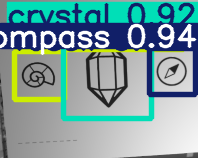

In [ ]:
#---------------------------------------------------------------------------------
# Cell 9: Test Inference with the Trained Model (Optional)
#---------------------------------------------------------------------------------
# You'll need a test image. Upload one or use one from your validation set for a quick check.
# Example: Using a validation image if your dataset structure is known
# (This is just an example, adjust the path to a real test image)
# TEST_IMAGE_PATH = "/content/generated_yolo_dataset/images/val/img_val_00001.png"

# Or upload a new test image
print("Please upload a test image to /content/test_image.jpg")
from google.colab import files
uploaded = files.upload()
if uploaded:
   TEST_IMAGE_PATH = list(uploaded.keys())[0]
else:
   TEST_IMAGE_PATH = None

if TEST_IMAGE_PATH and os.path.exists(TEST_IMAGE_PATH):
   !python detect.py \
       --weights "{PROJECT_NAME}/{EXPERIMENT_NAME}/weights/best.pt" \
       --img {IMAGE_SIZE} \
       --conf 0.5 \
       --source "{TEST_IMAGE_PATH}" \
       --project "/content/yolov5/runs/detect" \
       --name "colab_test_run" \
       --exist-ok

   # Display the result
   output_image_path = f"/content/yolov5/runs/detect/colab_test_run/{os.path.basename(TEST_IMAGE_PATH)}"
   if os.path.exists(output_image_path):
       display(Image(filename=output_image_path))
   else:
       print(f"Output image not found at {output_image_path}")
else:
   print("Test image not provided or not found.")

In [ ]:
#load as required
import os
import torch
drive_model_path = f"/content/drive/MyDrive/YoloProj/weights/best_yolov5n_expOverlapp2.pt"

# Check if the model file exists
if not os.path.exists(drive_model_path):
    print(f"ERROR: Model file not found at {drive_model_path}")
    print("Please ensure the EXPERIMENT_NAME is correct and the file exists in your Google Drive.")
else:
    print(f"Found model at: {drive_model_path}")

    # Load the model
    # The 'custom' argument tells YOLOv5 to load a custom-trained model.
    # It will automatically infer the model architecture (e.g., yolov5n) from the .pt file.
    try:
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=drive_model_path, force_reload=False)
        # force_reload=True if you suspect caching issues or want to ensure the latest from hub if not using a local path

        # If you prefer to load it directly using YOLOv5's attempt_load (more internal)
        # from models.experimental import attempt_load
        # model = attempt_load(drive_model_path, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        print("Model loaded successfully!")

        # You can now set the model to evaluation mode if you're doing inference
        model.eval()

        # Or keep it in training mode if you plan to continue training
        # model.train()

    except Exception as e:
        print(f"Error loading model: {e}")
        print("Ensure the YOLOv5 repository is correctly cloned and dependencies are installed.")
        print("Also, check if the .pt file is a valid YOLOv5 model checkpoint.")


Found model at: /content/drive/MyDrive/YoloProj/weights/best_yolov5n_expOverlapp2.pt


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-6-18 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1774048 parameters, 0 gradients, 4.2 GFLOPs
Adding AutoShape... 


Model loaded successfully!


In [ ]:
#---------------------------------------------------------------------------------
# Cell 11 Test Inference with the LOADED Model
#---------------------------------------------------------------------------------
import os
import cv2 # OpenCV for image loading if needed
from PIL import Image # For displaying images in Colab
from IPython.display import display

# Ensure the model was loaded successfully in a previous cell (e.g., Cell 3)
# It should be available as a variable named 'model'
if 'model' not in locals() or model is None:
    print("Model not loaded. Please run the cell that loads the model first (e.g., Cell 3).")
else:
    print("Using the model loaded in memory.")
    model.eval() # Ensure the model is in evaluation mode

    # --- Option 1: Upload a new test image ---
    print("\nPlease upload a test image:")
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        TEST_IMAGE_PATH_IN_COLAB = list(uploaded.keys())[0]
        print(f"Uploaded image: {TEST_IMAGE_PATH_IN_COLAB}")
    else:
        TEST_IMAGE_PATH_IN_COLAB = None
        print("No image uploaded.")

    # --- Option 2: Define a path to an existing image in Colab or Drive ---
    # Uncomment and use this if you have an image already available
    # TEST_IMAGE_PATH_IN_COLAB = "/content/drive/MyDrive/path_to_your_test_image.jpg" # Example for Drive
    # TEST_IMAGE_PATH_IN_COLAB = "/content/some_local_colab_image.jpg" # Example for local Colab FS

    if TEST_IMAGE_PATH_IN_COLAB and os.path.exists(TEST_IMAGE_PATH_IN_COLAB):
        try:
            print(f"\nPerforming inference on: {TEST_IMAGE_PATH_IN_COLAB}")

            # Perform inference
            # The model can take a file path, a PIL Image, a NumPy array (HWC, BGR),
            # or a list of these.
            model.conf = 0.6
            results = model(TEST_IMAGE_PATH_IN_COLAB)

            # Print results to console (bounding boxes, classes, confidences)
            print("\nDetection Results:")
            results.print()

            # Display the image with bounding boxes in Colab
            print("\nDisplaying image with detections:")
            results.show() # This internally uses PIL and IPython.display

            # To get more detailed information or manipulate results:
            # results.xyxy[0]  # im1 predictions (tensor) per image
            # results.pandas().xyxy[0]  # im1 predictions (pandas DataFrame) per image
            #      xmin    ymin    xmax   ymax  confidence  class    name
            # 0  749.50   43.50  1148.0  704.5    0.874023      0  person
            # 1  433.50  433.50   517.5  714.5    0.687988     27     tie

            # If you want to save the image with detections:
            save_dir = "/content/yolov5/runs/inference_with_loaded_model" # Define a save directory
            os.makedirs(save_dir, exist_ok=True)
            results.save(save_dir=save_dir) # Saves to the specified directory
            print(f"\nInference results (image with detections) saved to: {save_dir}")
            # The saved image filename will be the same as the input image name.
            # You can find it at: os.path.join(save_dir, os.path.basename(TEST_IMAGE_PATH_IN_COLAB))

        except Exception as e:
            print(f"An error occurred during inference: {e}")
            import traceback
            traceback.print_exc()
    else:
        if TEST_IMAGE_PATH_IN_COLAB: # Path was given but file doesn't exist
            print(f"Test image not found at the specified path: {TEST_IMAGE_PATH_IN_COLAB}")
        # If no image was uploaded and no path was set, this part is skipped.

Model not loaded. Please run the cell that loads the model first (e.g., Cell 3).


In [ ]:
# For class linup checking
# Assume 'model' is your loaded YOLOv5 model

if 'model' in locals() and model is not None:
    print("Inspecting model.names...")
    class_names_attribute = model.names
    print(f"Type of model.names: {type(class_names_attribute)}")

    if isinstance(class_names_attribute, dict):
        print("\nClass names (from dictionary format):")
        if not class_names_attribute:
            print("  Empty dictionary.")
        # Sort by key (class ID) for consistent order
        for class_id, name_str in sorted(class_names_attribute.items()):
            print(f"  Class ID {class_id}: {name_str}")
        num_classes = len(class_names_attribute)

    elif isinstance(class_names_attribute, list):
        print("\nClass names (from list format):")
        if not class_names_attribute:
            print("  Empty list.")
        for class_id, name_str in enumerate(class_names_attribute):
            print(f"  Class ID {class_id}: {name_str}")
        num_classes = len(class_names_attribute)
    else:
        print(f"\nmodel.names is of an unexpected type: {type(class_names_attribute)}")
        num_classes = 0 # Or try to get it from model.nc

    if num_classes > 0:
        print(f"\nTotal number of classes found: {num_classes}")

    # You can also check model.nc if it exists (number of classes)
    if hasattr(model, 'nc'):
        print(f"Model's number of classes attribute (model.nc): {model.nc}")
    elif hasattr(model, 'model') and hasattr(model.model, 'nc'): # For some encapsulations
        print(f"Model's number of classes attribute (model.model.nc): {model.model.nc}")


    # The results object also stores the names it used for inference
    # If you have a 'results' object from a previous inference:
    # if 'results' in locals() and results is not None:
    # print("\nNames used by the last 'results' object:")
    # print(results.names)

else:
    print("Model not loaded.")

Inspecting model.names...
Type of model.names: <class 'dict'>

Class names (from dictionary format):
  Class ID 0: emerald
  Class ID 1: coin
  Class ID 2: treasure_box
  Class ID 3: crystal
  Class ID 4: compass
  Class ID 5: diamond
  Class ID 6: coral
  Class ID 7: fossil
  Class ID 8: letter
  Class ID 9: key
  Class ID 10: shell

Total number of classes found: 11
